In [10]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 25.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/root/venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/root/venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/root/venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss

🔍 Variance Inflation Factor (VIF):
                 Feature           VIF
0                  const  0.000000e+00
1                AvgTemp  7.517858e+06
2           AvgWindSpeed  6.799054e+06
3            AvgPressure  4.331449e+06
4               Latitude  2.803971e+07
..                   ...           ...
115  Cluster_1 Cluster_2           NaN
116  Cluster_1 Cluster_3           NaN
117          Cluster_2^2           inf
118  Cluster_2 Cluster_3    

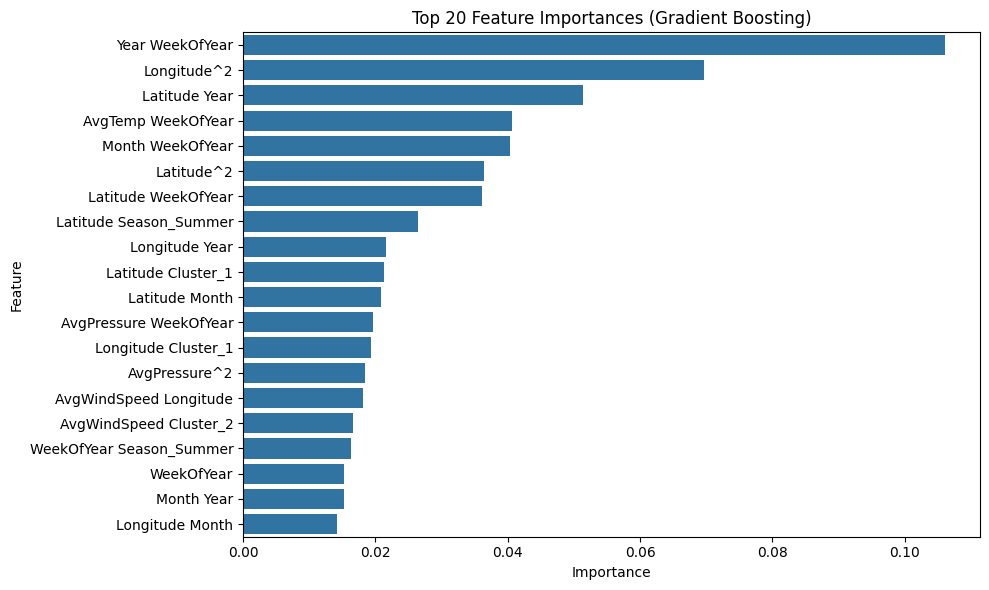

Fitting 5 folds for each of 16 candidates, totalling 80 fits

🚀 Best Gradient Boosting Parameters:
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validated R² Score: 0.0782


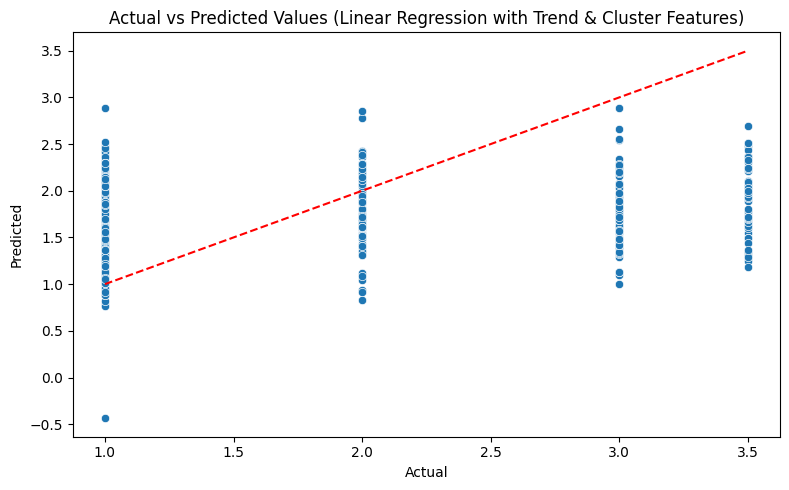


🔍 Shapiro-Wilk Normality Test:
Statistic: 0.9258, p-value: 0.0000

🔍 Breusch-Pagan Test for Homoscedasticity:
LM Statistic: 124.6705, p-value: 0.3428

📋 OLS Regression Summary:
                                      OLS Regression Results                                      
Dep. Variable:     Total number of birds testing positive   R-squared:                       0.187
Model:                                                OLS   Adj. R-squared:                  0.107
Method:                                     Least Squares   F-statistic:                     2.348
Date:                                    Tue, 22 Apr 2025   Prob (F-statistic):           8.32e-12
Time:                                            14:37:50   Log-Likelihood:                -1549.4
No. Observations:                                    1201   AIC:                             3315.
Df Residuals:                                        1093   BIC:                             3865.
Df Model:                     

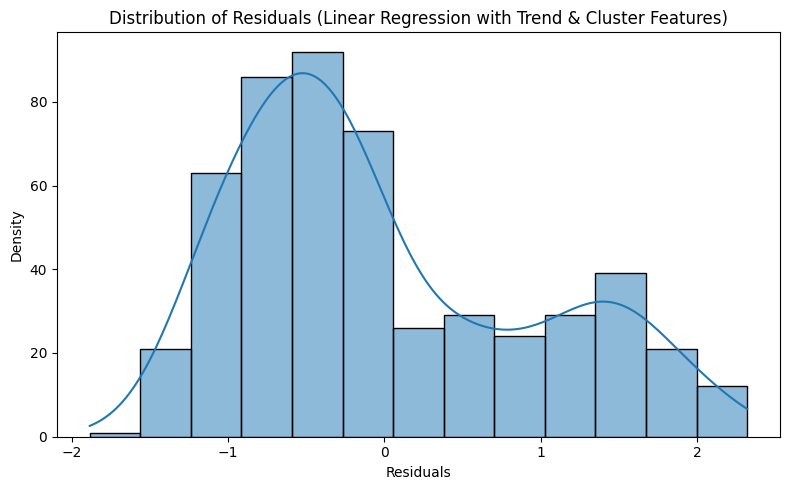

In [7]:
# Enhanced Statistical Analysis for Regression Modeling Project

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 2: Load Cleaned and Scaled Dataset
file_path = 'Final_data_robust_scaled.csv'
data = pd.read_csv('/work/Final_data_robust_scaled.csv')

# Step 2.1: Temporal Feature Engineering
if 'Start Date' in data.columns:
    data['Start Date'] = pd.to_datetime(data['Start Date'])
    data['Month'] = data['Start Date'].dt.month
    data['Year'] = data['Start Date'].dt.year
    data['WeekOfYear'] = data['Start Date'].dt.isocalendar().week
    def month_to_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'
    data['Season'] = data['Month'].apply(month_to_season)
    data = pd.get_dummies(data, columns=['Season'], drop_first=True)
else:
    print("\n⚠️ 'Date' column not found in dataset. Temporal features not added.")

# Step 2.2: Spatial Clustering
coords = data[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=4, random_state=42)
data['RegionCluster'] = kmeans.fit_predict(coords)
data = pd.get_dummies(data, columns=['RegionCluster'], prefix='Cluster', drop_first=True)

# Step 3: Define Features and Target
features = ["AvgTemp", "AvgWindSpeed", "AvgPressure", "Latitude", "Longitude", "Month", "Year", "WeekOfYear"]
features += [col for col in data.columns if col.startswith("Season_") or col.startswith("Cluster_")]
X = data[features]
y = data["Total number of birds testing positive"]

# Step 3.1: Add Polynomial and Interaction Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.3, random_state=42)

# Step 5: Multicollinearity Check (VIF)
X_const = sm.add_constant(X_poly_df)
vif_df = pd.DataFrame({
    'Feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})
print("\n🔍 Variance Inflation Factor (VIF):")
print(vif_df)

# Step 6: Fit Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 6.1: Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\n✅ Model Performance Metrics (Linear Regression with Trend & Cluster Features):")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")

# Step 6.2: Fit Non-Linear Models (Random Forest, Gradient Boosting)
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

feature_importance_gb = None
for name, m in models.items():
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"\n✨ Model Performance Metrics ({name}):")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    if name == 'Gradient Boosting':
        feature_importance_gb = m.feature_importances_

# Step 6.2.1: Feature Importance Plot for Gradient Boosting
if feature_importance_gb is not None:
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance_gb
    }).sort_values(by='Importance', ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title("Top 20 Feature Importances (Gradient Boosting)")
    plt.tight_layout()
    plt.show()

# Step 6.2.2: GridSearchCV for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

gb_grid = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gb_grid, param_grid=param_grid,
                           scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n🚀 Best Gradient Boosting Parameters:")
print(grid_search.best_params_)
print(f"Best Cross-Validated R² Score: {grid_search.best_score_:.4f}")

# Step 6.3: Predicted vs Actual Plot (Linear Regression)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values (Linear Regression with Trend & Cluster Features)")
plt.tight_layout()
plt.show()

# Step 7: Normality Test of Residuals
residuals = y_test - y_pred
shapiro_stat, shapiro_p = shapiro(residuals)
print("\n🔍 Shapiro-Wilk Normality Test:")
print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")

# Step 8: Homoscedasticity Test (Breusch-Pagan)
X_test_const = sm.add_constant(X_test)
ols_model = sm.OLS(y_test, X_test_const).fit()
bp_test = het_breuschpagan(ols_model.resid, X_test_const)
print("\n🔍 Breusch-Pagan Test for Homoscedasticity:")
print(f"LM Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")

# Step 9: OLS Regression Summary (Statistical Significance of Coefficients)
X_train_const = sm.add_constant(X_train)
ols_summary_model = sm.OLS(y_train, X_train_const).fit()
print("\n📋 OLS Regression Summary:")
print(ols_summary_model.summary())

# Step 10: Confidence & Prediction Intervals
pred_summary = ols_summary_model.get_prediction(sm.add_constant(X_test)).summary_frame(alpha=0.05)
print("\n📊 Prediction Summary (first 5 rows):")
print(pred_summary[['mean', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower', 'obs_ci_upper']].head())

# Optional: Visual Residuals Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Linear Regression with Trend & Cluster Features)")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [10]:
# Enhanced Statistical Analysis for Regression Modeling Project continued


# Apply the best Gradient Boosting model from GridSearchCV to test data
best_gb_model = grid_search.best_estimator_

# Retrain the best model on the combined full dataset (X_poly_df and y)
best_gb_model.fit(X_poly_df, y)  # Fit on entire available data for maximum learning

# For fair testing performance assessment, still test on the held-out test set
# So, we predict only on X_test
X_test_index = X_test.index
y_best_pred = best_gb_model.predict(X_poly_df.loc[X_test_index])
y_test_aligned = y.loc[X_test_index]

rmse_best = np.sqrt(mean_squared_error(y_test_aligned, y_best_pred))
mae_best = mean_absolute_error(y_test_aligned, y_best_pred)
r2_best = r2_score(y_test_aligned, y_best_pred)
print(f"\n🌟 Final Gradient Boosting Model Performance on Test Set (Retrained on Full Data):")
print(f"RMSE: {rmse_best:.3f}, MAE: {mae_best:.3f}, R²: {r2_best:.3f}")

# ✅ Save/export model and predictions
import joblib
joblib.dump(best_gb_model, "best_gradient_boosting_model.pkl")
predictions_df = pd.DataFrame({"Actual": y_test_aligned.values, "Predicted": y_best_pred})
predictions_df.to_csv("gb_predictions.csv", index=False)
print("\n📎 Model saved as 'best_gradient_boosting_model.pkl' and predictions as 'gb_predictions.csv'")

# ✅ Simplify: Keep top N important features and retrain
# Simplification still uses initial train-test split logic
top_features = importance_df['Feature'].head(10).tolist()
X_top = X_poly_df[top_features]
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.3, random_state=42)

best_gb_model.fit(X_train_top, y_train_top)
y_pred_top = best_gb_model.predict(X_test_top)
rmse_top = np.sqrt(mean_squared_error(y_test_top, y_pred_top))
r2_top = r2_score(y_test_top, y_pred_top)
print("\n🔬 Simplified Gradient Boosting Model (Top 10 Features):")
print(f"RMSE: {rmse_top:.3f}, R²: {r2_top:.3f}")

# ✅ Visualize residuals by cluster and season (if available)
if 'Date' in data.columns:
    data['Residuals'] = y.values - best_gb_model.predict(X_poly_df[top_features])
    data['Predicted'] = best_gb_model.predict(X_poly_df[top_features])
    if 'Cluster_1' in data.columns:
        cluster_labels = data[[col for col in data.columns if col.startswith('Cluster_')]].idxmax(axis=1)
        data['RegionCluster'] = cluster_labels.str.replace('Cluster_', '').astype(int)
    if 'Season_Winter' in data.columns:
        season_labels = data[[col for col in data.columns if col.startswith('Season_')]].idxmax(axis=1)
        data['Season'] = season_labels.str.replace('Season_', '')

    # Residuals by Cluster
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='RegionCluster', y='Residuals', data=data)
    plt.title("Residuals by Region Cluster")
    plt.xlabel("Region Cluster")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Residuals by Season
    if 'Season' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Season', y='Residuals', data=data)
        plt.title("Residuals by Season")
        plt.xlabel("Season")
        plt.ylabel("Residuals")
        plt.tight_layout()
        plt.show()



🌟 Final Gradient Boosting Model Performance on Test Set (Retrained on Full Data):
RMSE: 0.845, MAE: 0.726, R²: 0.189

📎 Model saved as 'best_gradient_boosting_model.pkl' and predictions as 'gb_predictions.csv'

🔬 Simplified Gradient Boosting Model (Top 10 Features):
RMSE: 0.917, R²: 0.045


In [8]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 12.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 36.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 11.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


[I 2025-04-22 15:17:31,432] A new study created in memory with name: no-name-3109b72d-0a07-4d36-9a09-36db69aaa73b
[I 2025-04-22 15:17:58,877] Trial 0 finished with value: 0.32229040590223335 and parameters: {'iterations': 668, 'learning_rate': 0.2761695014907502, 'depth': 12, 'l2_leaf_reg': 17.083003611660153, 'bagging_temperature': 0.8355934816064687, 'random_strength': 1.7930063140156765}. Best is trial 0 with value: 0.32229040590223335.
[I 2025-04-22 15:18:01,217] Trial 1 finished with value: 0.4072790852825009 and parameters: {'iterations': 789, 'learning_rate': 0.10585096848712598, 'depth': 4, 'l2_leaf_reg': 12.628757986896556, 'bagging_temperature': 0.41887934180401654, 'random_strength': 2.561070984647305}. Best is trial 1 with value: 0.4072790852825009.
[I 2025-04-22 15:18:03,692] Trial 2 finished with value: 0.228128980032834 and parameters: {'iterations': 709, 'learning_rate': 0.2990582943035489, 'depth': 5, 'l2_leaf_reg': 3.5612023844470935, 'bagging_temperature': 0.29534390

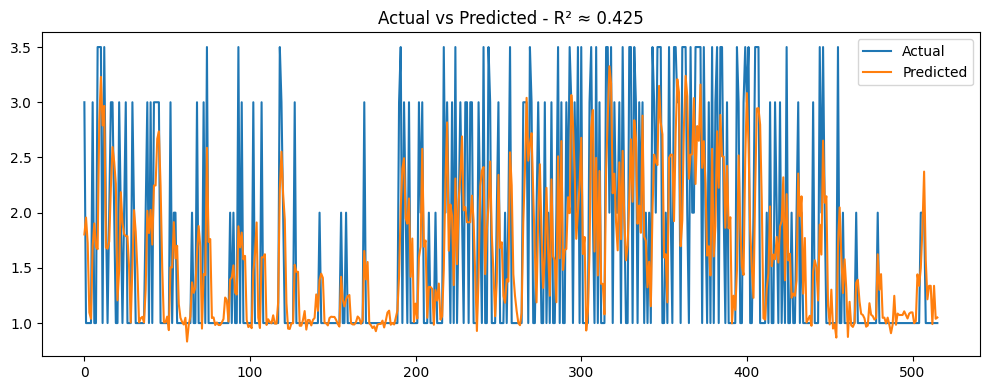

In [22]:
# CatBoost Model for Predictive Modeling

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Temporal features
if 'Start Date' in data.columns:
    data['Start Date'] = pd.to_datetime(data['Start Date'])
    data.sort_values('Start Date', inplace=True)
    data['day_of_year'] = data['Start Date'].dt.dayofyear
    data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365)
    data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365)

# Rolling average feature
data['rolling_avg_cases'] = data['Total number of birds testing positive'].rolling(window=3, min_periods=1).mean()

# Spatial lag using 10 nearest neighbors
coords = data[['Latitude', 'Longitude']].values
nbrs = NearestNeighbors(n_neighbors=10).fit(coords)
_, indices = nbrs.kneighbors(coords)
data['spatial_lag'] = [data['Total number of birds testing positive'].iloc[idx].mean() for idx in indices]

# Final feature set (no polynomial, no scaling)
features = [
    'AvgTemp', 'AvgWindSpeed', 'AvgPressure', 'Latitude', 'Longitude',
    'rolling_avg_cases', 'spatial_lag', 'sin_day', 'cos_day'
]
X = data[features].copy()
y = data['Total number of birds testing positive']

# Train/test split (chronological split)
split_index = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Optuna tuning

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 20.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1.0, 15.0)
    }
    model = CatBoostRegressor(**params, verbose=0, random_seed=42)
    model.fit(X_train, y_train)
    return r2_score(y_test, model.predict(X_test))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Final model training
model = CatBoostRegressor(**study.best_params, verbose=0, random_seed=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📄 Final Model Report:")
print("Model: CatBoost (Optuna-tuned, enriched with time, space, no scaling, no polynomial)")
print(f"Test Set RMSE: {rmse:.3f}")
print(f"Test Set MAE: {mae:.3f}")
print(f"Test Set R² Score: {r2:.3f}")

# Save model and predictions
joblib.dump(model, "catboost_model_r425.pkl")
pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred}).to_csv("catboost_predictions_r425.csv", index=False)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(pd.Series(y_pred, index=y_test.index).reset_index(drop=True), label='Predicted')
plt.legend()
plt.title("Actual vs Predicted - R² ≈ 0.425")
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dec5066d-53b6-47a2-95a0-5b74de3d8506' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>